# Overlay of microwave and optical remote sensing dataset

### Imports

Both datasets are projected onto the same coordinate systems
- Input coordinate system for X and Y (EPSG: 3413): WGS 84 / NSIDC Sea Ice Polar Stereographic North
- Output coordinate system for long and lat (EPSG: 4468): Cartesian 2D CS for north polar azimuthal lonO 45°W. Axes: X,Y. Orientations: X along 45°E, Y along 135°E meridians. UoM: m.

Useful links:
- info about ESG:3413: https://epsg.io/3413
- info about EPSG:4468: https://epsg.io/4468-cs
- UI to play around with CRS coordinates: https://epsg.io/map#srs=3413&x=944379.792439&y=-944379.792439&z=2&layer=streets

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import rioxarray
import xarray
import rasterio


%matplotlib inline

### Load data

In [3]:
mw_path = r"../Data/microwave-rs/CumJour-North-ssmi-1979-2022-H19.nc"
opt_path = r"../Data/optical-rs/2019-06-08_grain_diameter.tif"

In [4]:
data_mw = xarray.open_dataset(mw_path).rio.write_crs("epsg:3413", inplace=True) # add EPSG
data_mw = data_mw.where(data_mw["time"] == np.datetime64('2019-06-08'), drop=True)["melt"] # only use one day for now
data_opt = xarray.open_dataarray(opt_path)

In [5]:
def print_raster(raster):
    print(
        f"shape: \n   Y: {raster.rio.shape[0]} \n   X: {raster.rio.shape[1]}\n"
        f"resolution: {raster.rio.resolution()}\n"
        f"bounds: \n   minx = {raster.rio.bounds()[0]} \n   miny = {raster.rio.bounds()[1]} \n   maxx = {raster.rio.bounds()[2]} \n   maxy = {raster.rio.bounds()[3]}\n"
        f"sum: {raster.sum().item()}\n"
        f"CRS: {raster.rio.crs}\n"
    )

### Inspect data

In [ ]:
print("Microwave Raster:\n----------------")
print_raster(data_mw)
print("Optical Raster:\n----------------")
print_raster(data_opt)

In [28]:
data_mw

<xarray.DataArray 'melt' (time: 1, y: 109, x: 60)>
array([[[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 2019-06-08
  * x            (x) float64 -6.5e+05 -6.25e+05 -6e+05 ... 8e+05 8.25e+05
  * y            (y) float64 -6.25e+05 -6.5e+05 ... -3.3e+06 -3.325e+06
    spatial_ref  int64 0
Attributes:
    long_name:     Surface melt
    units:         
    grid_mapping:  spatial_ref

In [31]:
data_opt.rio.bounds()

(-637000.0, -3349000.0, 850000.0, -662000.0)

In [33]:
data_opt.y.min()

<xarray.DataArray 'y' ()>
array(-3348500.)
Coordinates:
    spatial_ref  int64 0

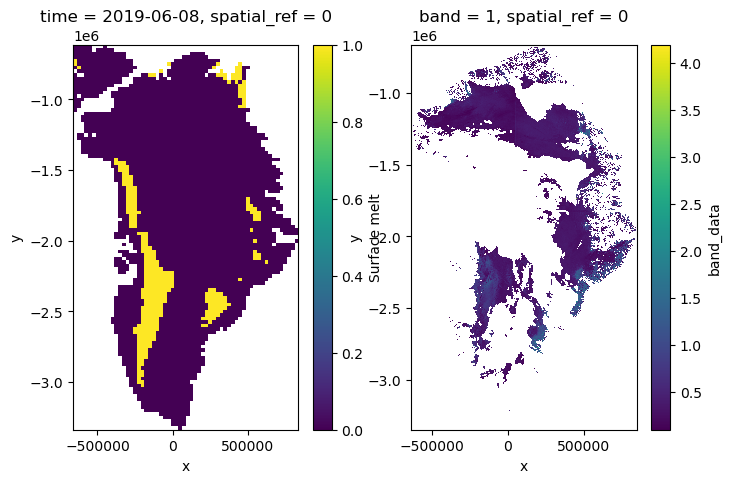

In [81]:
# fig, axes = plt.subplots(ncols=2, figsize=(8,5))
# data_mw.plot(ax=axes[0])
# data_opt.plot(ax=axes[1])
# plt.draw()

In [101]:
data_repr_mw = data_opt.rio.reproject_match(data_mw)

print("Reprojected Raster:\n-------------------")
print_raster(data_repr_mw)

Reprojected Raster:
-------------------
shape: 
   Y: 109 
   X: 60
resolution: (25000.0, -25000.0)
bounds: 
   minx = -662500.0 
   miny = -3337500.0 
   maxx = 837500.0 
   maxy = -612500.0
sum: 535.418212890625
CRS: EPSG:3413



In [107]:
data_repr_mw

<xarray.DataArray 'band_data' (band: 1, y: 109, x: 60)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * x            (x) float64 -6.5e+05 -6.25e+05 -6e+05 ... 8e+05 8.25e+05
  * y            (y) float64 -6.25e+05 -6.5e+05 ... -3.3e+06 -3.325e+06
  * band         (band) int32 1
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area

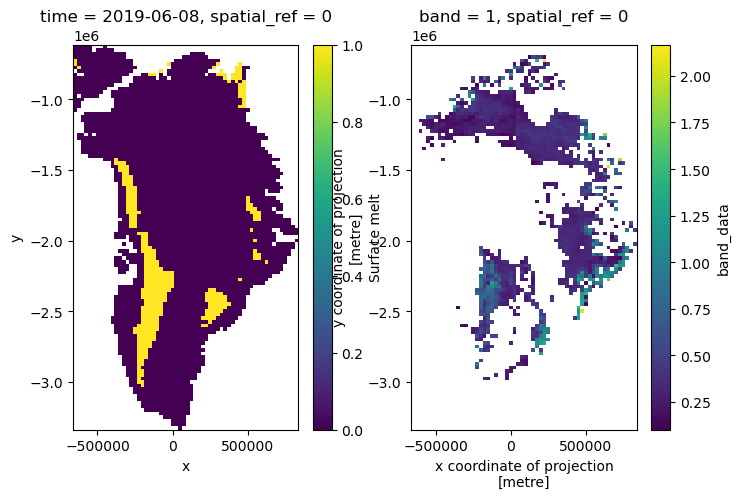

In [103]:
fig, axes = plt.subplots(ncols=2, figsize=(8,5))
data_mw.plot(ax=axes[0])
data_repr_mw.plot(ax=axes[1])
plt.draw()

In [113]:
data_repr_mw = data_repr_mw.assign_coords({
    "x": data_mw.x,
    "y": data_mw.y,
})
data_sum = data_repr_mw + data_mw

In [115]:
print("Sum Raster:\n-----------")
print_raster(data_sum)

Sum Raster:
-----------
shape: 
   Y: 109 
   X: 60
resolution: (25000.0, -25000.0)
bounds: 
   minx = -662500.0 
   miny = -3337500.0 
   maxx = 837500.0 
   maxy = -612500.0
sum: 674.22021484375
CRS: EPSG:3413



In [ ]:
# fig, axes = plt.subplots(ncols=3, figsize=(12,5))

# data_repr_mw.plot(ax=axes[0])
# data_mw.plot(ax=axes[1])
# data_sum.plot(ax=axes[2])

# plt.draw()

The brighter the color in the right plot, the more accordance regarding melting between both datasets

## Continue

**ToDo**

- shift pixels/ coordinates (+- 500 to each value)
- check several pixels if corners match
- need to figure out if bounds are universal for all pictures or have to bet individually which might be a paaain

- dataset.transform is the transformation function
- get pixels with transform function
- use Vedran's code
- 

### 5.

In [ ]:
#shift pixels of coarse dataset
#+500 

In [6]:
from osgeo import gdal

In [9]:
data_mw = xarray.open_dataset(mw_path).rio.write_crs("epsg:3413", inplace=True) # add EPSG
data_mw = data_mw.where(data_mw["time"] == np.datetime64('2019-06-08'), drop=True)["melt"] # only use one day for now
data_opt = xarray.open_dataarray(opt_path)

data_mw.rio.to_raster( 'data_mw_tif.tif')
data_omv_tif = xarray.open_dataarray('data_mw_tif.tif')

In [97]:
data_mw['x'] = [i+500 for i in data_mw['x']]
data_mw['y'] = [i-500 for i in data_mw['y']]

In [ ]:
# need to fix scale and nans!!!

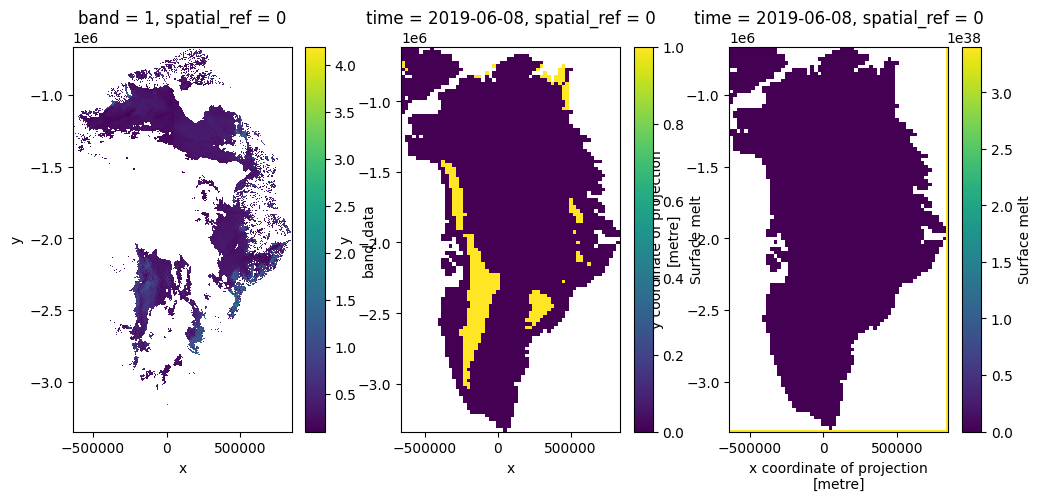

In [100]:
fig, axes = plt.subplots(ncols=3, figsize=(12,5))
data_opt.plot(ax=axes[0])
data_mw.plot(ax=axes[1])
data_repr_mw.plot(ax=axes[2])
plt.draw()

In [99]:
data_repr_mw = data_mw.rio.reproject_match(data_opt) # raster to match in parenth - try make mw to opt resolution

print("Reprojected Raster:\n-------------------")
print_raster(data_repr_mw)

Reprojected Raster:
-------------------
shape: 
   Y: 2687 
   X: 1487
resolution: (1000.0, -1000.0)
bounds: 
   minx = -637000.0 
   miny = -3349000.0 
   maxx = 850000.0 
   maxy = -662000.0
sum: inf
CRS: EPSG:3413



/mnt/c/Users/linas/OneDrive/Documents/ITU/Semester3/RP_Greenland/RP_Greenland/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [ ]:
# make matrix of zeros (with size ... opt?)
# go through matrix and with transform function fill.
# transforfm function will map pixel values from mw data to matrix (to avoid interpolation)


### Change resolution all - FAILED
code from here to be ignored for now

1. higher resolution optical

In [11]:
# check current resolution
print_raster(data_opt) 

shape: 
   Y: 2687 
   X: 1487
resolution: (1000.0, -1000.0)
bounds: 
   minx = -637000.0 
   miny = -3349000.0 
   maxx = 850000.0 
   maxy = -662000.0
sum: 324417.8125
CRS: EPSG:3413



In [40]:
# rasterio's transform attribute https://rasterio.readthedocs.io/en/latest/quickstart.html

from rasterio.enums import Resampling

image = r"../Data/optical-rs/2019-06-08_grain_diameter.tif"
upscale_factor = 2

with rasterio.open(image) as dataset:

    # resample data to target shape using upscale_factor
    data = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )

   
    # print('Shape before resample:', dataset.shape)
    # print('Shape after resample:', data.shape[1:])

    # scale image transform
    dst_transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )B

    # print('Transform before resample:\n', dataset.transform, '\n')
    # print('Transform after resample:\n', dst_transform)

    ## Write outputs
    # set properties for output

    #rasterio.warp.reproject(    )

    dst_kwargs = dataset.meta.copy()
    dst_kwargs.update(
        {
            "transform": dst_transform,
            "width": data.shape[-1],
            "height": data.shape[-2],
            #"nodata": 0,  
        }
    )


Shape before resample: (2687, 1487)
Shape after resample: (5374, 2974)
Transform before resample:
 | 1000.00, 0.00,-637000.00|
| 0.00,-1000.00,-662000.00|
| 0.00, 0.00, 1.00| 

Transform after resample:
 | 500.00, 0.00,-637000.00|
| 0.00,-500.00,-662000.00|
| 0.00, 0.00, 1.00|


In [41]:
with rasterio.open("temp-2019-06-08_grain_diameter.tif", "w", **dst_kwargs) as dst:
    # iterate through bands
    for i in range(data.shape[0]):
            dst.write(data[i].astype(rasterio.uint32), i+1)

In [43]:
# open above rewritten array
data_opt_temp = xarray.open_dataarray("temp-2019-06-08_grain_diameter.tif")

In [54]:
data_opt_temp[0]
# whyy these values and not nan same as before?

<xarray.DataArray 'band_data' (y: 5374, x: 2974)>
array([[2.147484e+09, 2.147484e+09, 2.147484e+09, ..., 2.147484e+09,
        2.147484e+09, 2.147484e+09],
       [2.147484e+09, 2.147484e+09, 2.147484e+09, ..., 2.147484e+09,
        2.147484e+09, 2.147484e+09],
       [2.147484e+09, 2.147484e+09, 2.147484e+09, ..., 2.147484e+09,
        2.147484e+09, 2.147484e+09],
       ...,
       [2.147484e+09, 2.147484e+09, 2.147484e+09, ..., 2.147484e+09,
        2.147484e+09, 2.147484e+09],
       [2.147484e+09, 2.147484e+09, 2.147484e+09, ..., 2.147484e+09,
        2.147484e+09, 2.147484e+09],
       [2.147484e+09, 2.147484e+09, 2.147484e+09, ..., 2.147484e+09,
        2.147484e+09, 2.147484e+09]], dtype=float32)
Coordinates:
    band         int64 1
  * x            (x) float64 -6.368e+05 -6.362e+05 ... 8.492e+05 8.498e+05
  * y            (y) float64 -6.622e+05 -6.628e+05 ... -3.348e+06 -3.349e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area

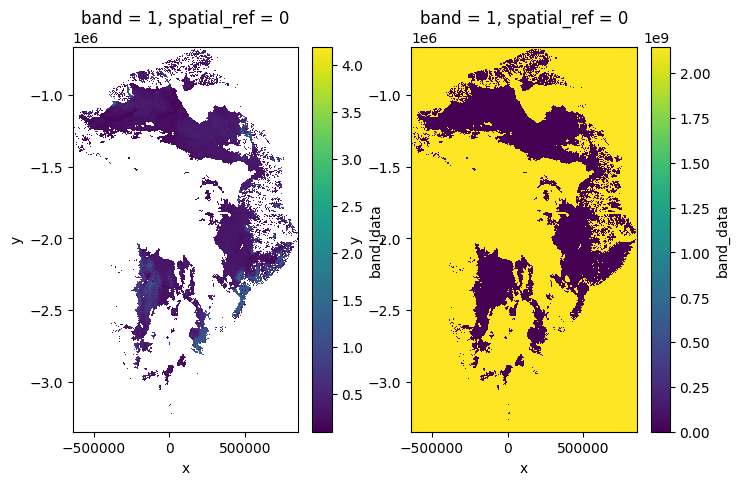

In [79]:
fig, axes = plt.subplots(ncols=2, figsize=(8,5))
data_opt.plot(ax=axes[0])
data_opt_temp.plot(ax=axes[1])
plt.draw()

In [ ]:
# seems to have lost a lot of information

# figure out what went wrong:
# looks like inverted and lost gray gradient
# maybe rasterize intead of writing??

In [46]:
print('ORIG:')
print_raster(data_opt) 
print('NEW:')
print_raster(data_opt_temp) 

ORIG:
shape: 
   Y: 2687 
   X: 1487
resolution: (1000.0, -1000.0)
bounds: 
   minx = -637000.0 
   miny = -3349000.0 
   maxx = 850000.0 
   maxy = -662000.0
sum: 324417.8125
CRS: EPSG:3413

NEW:
shape: 
   Y: 5374 
   X: 2974
resolution: (500.0, -500.0)
bounds: 
   minx = -637000.0 
   miny = -3349000.0 
   maxx = 850000.0 
   maxy = -662000.0
sum: 2.6907128295849984e+16
CRS: EPSG:3413



In [61]:
with rasterio.open(image) as dataset:

    # resample data to target shape using upscale_factor
    data1 = dataset.read()

In [65]:
data1.shape # (1, 2687, 1487)
data.shape #(1, 5374, 2974)

(1, 2687, 1487)

In [77]:
np.unique(data) # 2974

array([-3.4028235e+38,  1.0000482e-01,  1.0002153e-01, ...,
        3.6269281e+00,  3.6706243e+00,  3.9512947e+00], dtype=float32)

In [78]:
np.unique(data1) # size 1487

array([-3.4028235e+38,  1.0000482e-01,  1.0002153e-01, ...,
        3.7645121e+00,  3.9512947e+00,  4.1958375e+00], dtype=float32)

In [58]:
band_id = 1  

raster = rasterio.open(opt_path) #,masked=True)
band_arr = raster.read(band_id)  # band_arr is a numpy array of shape (raster.width, raster.height)


print(band_arr.shape)
np.unique(band_arr)

(2687, 1487)


array([-3.4028235e+38,  1.0000482e-01,  1.0002153e-01, ...,
        3.7645121e+00,  3.9512947e+00,  4.1958375e+00], dtype=float32)

In [59]:
band_id = 1  

raster = rasterio.open("temp-2019-06-08_grain_diameter.tif") #,masked=True)
band_arr = raster.read(band_id)  # band_arr is a numpy array of shape (raster.width, raster.height)


print(band_arr.shape)
np.unique(band_arr)

(5374, 2974)


array([0.0000000e+00, 1.0000000e+00, 2.0000000e+00, 3.0000000e+00,
       2.1474836e+09], dtype=float32)

In [17]:
# shape_ = 1487, 2687
# test_transform = rasterio.transform.from_bounds(*data_opt.rio.bounds(), *shape_) # west, south, east, north, width, height

2. higher resolution microwave

3. cut

In [22]:
# cut microwave
upper_left_x = -637500.0 #-637000.0
upper_left_y = -662500.0 #-637500.0 #-662000.0 # fix
lower_right_x = 837500.0  #837500.0
lower_right_y = -3312500.0 #-3337500.0
window = (upper_left_x,upper_left_y,lower_right_x,lower_right_y)

gdal.Translate('output_crop_raster_mw.tif', 'test_mw_to_tiff.tif', projWin = window)


data_opt_cropped = xarray.open_dataarray('output_crop_raster_mw.tif')
print_raster(data_opt_cropped)

shape: 
   Y: 106 
   X: 59
resolution: (25000.0, -25000.0)
bounds: 
   minx = -637500.0 
   miny = -3312500.0 
   maxx = 837500.0 
   maxy = -662500.0
sum: 356.0
CRS: EPSG:3413



In [24]:
# cut optical
upper_left_x = -637500.0 #-637000.0
upper_left_y = -662500.0 #-637500.0 #-662000.0 # fix
lower_right_x = 837500.0  #837500.0
lower_right_y = -3312500.0 #-3337500.0
window = (upper_left_x,upper_left_y,lower_right_x,lower_right_y)

gdal.Translate('output_crop_raster.tif', opt_path, projWin = window)

data_opt_cropped = xarray.open_dataarray('output_crop_raster.tif')
print_raster(data_opt_cropped)

shape: 
   Y: 2650 
   X: 1475
resolution: (1000.0, -1000.0)
bounds: 
   minx = -638000.0 
   miny = -3312000.0 
   maxx = 837000.0 
   maxy = -662000.0
sum: 324280.21875
CRS: EPSG:3413



4. lower resolution